# 5. Análisis de tópicos con LDA (Latent Dirichlet Allocation)

## 5.1 Motivación

El __análisis de tópicos__ permite descubrir, a partir de los propios textos, el conjunto de tópicos que estos abordan. Se trata de un análisis automatizado, que podría ser difícil de llevar a cabo manualmente, debido a la cantidad de textos.

Uno de los algoritmos más comunes para analizar tópicos es el algoritmo _Latent Dirichlet Allocation (LDA)_ (Artículo "Latent Dirichlet Allocation" : https://drive.google.com/file/d/1BobImO3192hifZPLXowd14gryVAUzBPW/view)

__¿Qué hace LDA?__

Dado un número de tópicos definido por el analista, el modelo permite asociar una distribución de tópicos $\theta_d$ a cada texto $d$ y al mismo tiempo, la distribución de palabras $\beta_t$ en cada tópico $t$.

<img src="img/f1.jpg"/>

<img src="img/f2.jpg"/>

## 5.2 ¿Cómo hacer un análisis de tópicos en Python?

En este tutorial, tomaremos un dataset de noticias de prensa en español del mes de febrero 2021 y utilizaremos LDA para descubrir cuáles son los tópicos de las noticias.

### 5.2.1 Cargar el dataset de noticias

In [1]:
import pandas

# leer el archivo CSV
archivo = "./data/catrillanca.csv"
corpus = pandas.read_csv(archivo)

In [2]:
corpus.head(5)

,Unnamed: 0,id_news,country,media_outlet,url,title,text,date
0,0,243393.0,chile,horas24,https://www.24horas.cl/nacional/instituto-naci...,Instituto Nacional de Derechos Humanos amplía ...,El Instituto Nacional de Derechos Humanos (IND...,2019-06-22
1,1,5163425.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/268476-pa...,Padre de Catrillanca solicita presencia de Bac...,Hasta el Palacio de la Moneda llegó Marcelo Ca...,2019-07-17
2,2,13829736.0,chile,emol,https://www.emol.com/noticias/Nacional/2019/03...,"Adolescente que acompañaba a Catrillanca: ""Hab...",SANTIAGO.- A casi cuatro meses de la muerte de...,2019-03-10
3,3,5439896.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/245535-ca...,Cartas enviadas a familia de Camilo Catrillanc...,"Hace unos días Marcelo Catrillanca, padre de C...",2018-12-30
4,4,5442943.0,chile,ahoranoticiasmega,https://www.meganoticias.cl/nacional/245302-ca...,Caso Catrillanca: Comuneros mapuche se toman l...,"Durante la mañana de este jueves, un grupo de ...",2018-12-27


- Son 2.931 noticias en total.

In [4]:
len(corpus)

2931

- Creamos una lista de noticias a partir del corpus

In [5]:
noticias = corpus.text.values.tolist()

In [6]:
noticias[0]

'El Instituto Nacional de Derechos Humanos (INDH) solicitó al Juzgado de Garantía de Collipulli ampliar la querella por la muerte de Camilo Catrillanca, fallecido el 14 de noviembre de 2018 durante un operativo policial en la región de la Araucanía. De acuerdo lo que consigna el INDH en su sitio web, ya han presentado cuatro acciones judiciales en el caso. Se trata de una querella por el homicidio de Catrillanca, una por obstrucción a la investigación, una por el homicidio frustrado del adolescente de 15 años que acompañaba a Camilo Catrillanca la jornada de su muerte, además de las querellas por torturas que habría sufrido este último tras ser detenido. La organización también plantea que ha prestado apoyo y acompañamiento a la familia de Camilo Catrillanca en las distintas aristas tras la muerte del joven dirigente mapuche. Además, indican que han participado de procesos como la observación ocular de la autopsia del cuerpo de Catrillanca, la reconstitución de la escena de los eventos

### 5.2.2  Instalación de librerias

- Instalamos en nuestra máquina la libreria "pyLDAvis" que permite visualizar los resultados del análisis de tópicos 

Note bene: los comandos "pip install .." solo se hacen una vez para descargar las librerias en su computador.

In [10]:
#!pip install pyLDAvis

- Utilizaremos spacy para procesar textos en español (no es útil instalar la libreria con "pip instal..." ya que ya lo hicimos en notebook anterior)

In [8]:
import spacy
from spacy.matcher import Matcher
nlp = spacy.load("es_core_news_sm")
matcher = Matcher(nlp.vocab)

- Utilizaremos Gensim (para el análisis de tópicos) y pyLDAvis (para visualizar los tópicos)

In [10]:
import numpy as np
import pandas as pd

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

### 5.2.3 Preprocesamiento de las noticias

Procesaremos todas las noticias para representarlas como una lista de:
- sustantivos (NOUN)
- y conceptos claves (NOUN-de-NOUN) y (NOUN-ADJ)
- entidades (PER) y (ORG)

- Agregamos patrones para buscar conceptos claves

In [11]:
pattern_1 = [{"POS": "NOUN"},{"LOWER": "de"}, {"POS": "NOUN"}]
matcher.add("NOUN-de-NOUN", [pattern_1])

pattern_2 = [{"POS": "NOUN"}, {"POS": "ADJ"}]
matcher.add("NOUN-ADJ", [pattern_2])

- Definemos una función para preprocesar una noticia y transformarla en una lista de "palabras" relevantes.

In [13]:
def text_to_list(noticia):
    list_of_words = []
    
    try:
        doc = nlp(noticia)

        for token in doc:
            if (token.pos_=="NOUN"):
                list_of_words.append(token.text)

        for ent in doc.ents:
            if (ent.label_ == "PER" and " " in ent.text):
                list_of_words.append(ent.text)

        matches = matcher(doc)

        for match_id, start, end in matches:
            span = doc[start:end]  # The matched span
            list_of_words.append(span.text)
    
    except Exception as e: 
        print(noticia)
        print(e)
    
    return list_of_words

In [14]:
text_to_list(noticias[0])

['querella',
 'muerte',
 'noviembre',
 'operativo',
 'región',
 'acuerdo',
 'sitio',
 'acciones',
 'caso',
 'querella',
 'homicidio',
 'obstrucción',
 'investigación',
 'homicidio',
 'adolescente',
 'años',
 'jornada',
 'muerte',
 'querellas',
 'torturas',
 'organización',
 'apoyo',
 'acompañamiento',
 'familia',
 'aristas',
 'muerte',
 'joven',
 'procesos',
 'observación',
 'autopsia',
 'cuerpo',
 'reconstitución',
 'escena',
 'eventos',
 'toma',
 'declaración',
 'uniformados',
 'operativo',
 'proceso',
 'investigación',
 'caso',
 'plazo',
 'semanas',
 'petición',
 'defensa',
 'peritajes',
 'Juzgado de Garantía',
 'Camilo Catrillanca',
 'Camilo Catrillanca',
 'Camilo Catrillanca',
 'operativo policial',
 'sitio web',
 'acciones judiciales',
 'homicidio frustrado',
 'joven dirigente',
 'observación ocular',
 'toma de declaración',
 'declaración de uniformados',
 'uniformados involucrados',
 'proceso de investigación',
 'investigación judicial']

- Transformamos todas las noticias de nuestro corpus "noticias" aplicando la función "text_to_list". De cierta manera, simplificará el texto guardando solamente las palabras y conceptos importantes.

In [15]:
noticias_procesadas = []

for index, noticia in enumerate(noticias):
    print(index)
    noticia_procesada = text_to_list(noticia)
    noticias_procesadas.append(noticia_procesada)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


- Veamos cómo se transformó una cierta noticia. La variable "N" representa el rango de la noticia en nuestro corpus.

In [16]:
N=5

In [17]:
print(noticias[N])

Marcelo Catrillanca, padre del comunero mapuche asesinado, se refirió al nuevo video correspondiente a una segunda cámara que estaba en poder de uno de los excarabineros que participó en el operativo del pasado 14 de noviembre donde murió Camilo Catrillanca. "Nosotros siempre dijimos la verdad, que ese video existía. Siguen apareciendo evidencias", sostuvo Catrillanca desde el Congreso. En ese sentido, manifestó que "estaban todos informados, por lo que ellos querían ocultar la verdad". En particular, apuntó a la responsabilidad del general director de Carabineros, Hermes Soto, señalando que él mintió. "Tiene que ser imputado y condenado porque ocultó la verdad que los funcionarios que estaban a su cargo, lo hicieron", sostuvo el padre de Catrillanca. "Creo que el general director de Carabineros debería dar un paso al costado, así como el ministro del Interior, Andrés Chadwick", sostuvo. Agregó, que "nosotros queremos saber quién mató a mi hijo". Marcelo Catrillanca presentó durante es

- Se simplificó en:

In [18]:
print(noticias_procesadas[5])

['padre', 'comunero', 'video', 'cámara', 'poder', 'excarabineros', 'operativo', 'noviembre', 'verdad', 'video', 'evidencias', 'sentido', 'verdad', 'particular', 'responsabilidad', 'general', 'director', 'verdad', 'funcionarios', 'cargo', 'padre', 'general', 'director', 'paso', 'costado', 'ministro', 'hijo', 'jornada', 'carta', 'esclarecimiento', 'Marcelo Catrillanca', 'Camilo Catrillanca', 'Hermes Soto', 'Marcelo Catrillanca', 'video correspondiente', 'esclarecimiento histórico']


### 5.2.4 Preparar los datos de entrada de LDA

los datos de entrada de LDA son: 
- un diccionario (variable 'id2word')
- nuestro dataset preprocesado ('noticias_procesadas')

In [19]:
# Create Dictionary
id2word = corpora.Dictionary(noticias_procesadas)
id2word

- Se asigna una ID a cada palabra (o concepto) del vocabulario. Por ejemplo con el ID=25 corresponde a la palabra:

In [20]:
id2word[25]

'joven dirigente'

In [21]:
texts = noticias_procesadas

- Ahora una noticia se vuelve imposible de leer para un humano. Miremos por ejemplo la noticia N.

In [23]:
dataset = [id2word.doc2bow(noticia_procesada) for noticia_procesada in noticias_procesadas]

# View
print(dataset[:N])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1)], [(0, 2), (24, 1), (26, 2), (27, 1), (31, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 2), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 2), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1)], [(0, 2), (6, 5), (10, 1), (11, 1), (23, 1), (26, 4), (27, 1), (63, 1), (67, 2), (68, 2), (71, 3), (83, 4), (93, 1), (94, 1),

### 4. Entrenamiento del modelo de tópico con LDA

- Entrenaremos un primer modelo de tópicos buscando un modelo con 10 tópicos. 

In [24]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

- Guardaremos el modelo en el disco duro

In [42]:
lda_model.save('./output/lda_model_catrillanca_5')

### 5. Visualizar los tópicos encontrados

- Se puede imprimir los tópicos con sus principales palabras principales...

In [31]:
from pprint import pprint

pprint(lda_model.print_topics(num_words=25))

[(0,
  '0.022*"años" + 0.012*"prisión" + 0.010*"libertad" + 0.009*"caso" + '
  '0.008*"juicio" + 0.007*"pandemia" + 0.007*"hija" + 0.007*"delitos" + '
  '0.006*"abogado" + 0.006*"cárcel" + 0.006*"homicidio" + '
  '0.005*"investigación" + 0.005*"delito" + 0.005*"abogada" + 0.005*"octubre" '
  '+ 0.005*"revuelta" + 0.004*"juez" + 0.004*"tribunal" + 0.004*"día" + '
  '0.004*"pena" + 0.004*"prisión preventiva" + 0.004*"enero" + 0.004*"fiscal" '
  '+ 0.004*"días" + 0.003*"mayo"'),
 (1,
  '0.015*"“" + 0.013*"general" + 0.011*"policía" + 0.011*"fiscal" + 0.010*"”" '
  '+ 0.009*"institución" + 0.008*"caso" + 0.008*"parte" + 0.008*"director" + '
  '0.007*"funcionarios" + 0.007*"Camilo Catrillanca" + 0.007*"carabineros" + '
  '0.006*"investigación" + 0.006*"años" + 0.006*"hechos" + 0.006*"personas" + '
  '0.005*"día" + 0.005*"momento" + 0.005*"noviembre" + 0.005*"muerte" + '
  '0.005*"horas" + 0.005*"información" + 0.005*"fiscalía" + 0.005*"comunero" + '
  '0.005*"hecho"'),
 (2,
  '0.096*"}" + 0

- ... o se puede visualizar mejor con la libreria pyLDAvis

Nota bene: el número que identifica los topicos puede cambiar... 

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, dataset, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.248954  0.014926       1        1  48.452998
1      0.192643  0.079896       2        1  34.337181
3     -0.029868 -0.307849       3        1   9.293219
0     -0.119551  0.196607       4        1   4.997355
2     -0.292178  0.016420       5        1   2.919247, topic_info=           Term         Freq        Total Category  logprob  loglift
3153          }  1015.000000  1015.000000  Default  30.0000  30.0000
10         años  2132.000000  2132.000000  Default  29.0000  29.0000
3152          {   581.000000   581.000000  Default  28.0000  28.0000
196    gobierno  2448.000000  2448.000000  Default  27.0000  27.0000
11         caso  2068.000000  2068.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
4071       type    45.544807    45.926778   Topic5  -5.4507   3.5255
5428  jugadores    56.604676    57.264433   Topic5  -5.2333   3.5223
949       color    98.067248   131.923014   Topic5  -4.6837   3.2373
1519     imagen    66.213758   263.137585   Topic5  -5.0765   2.1541
3200          ]    55.587676   122.902301   Topic5  -5.2514   2.7404

[314 rows x 6 columns], token_table=       Topic      Freq                      Term
term                                            
771        5  0.997652                         #
38693      5  0.988475  #emolmlt-votacion-senado
4043       5  1.001594                        //
773        1  0.545574                      2018
773        2  0.033267                      2018
...      ...       ...                       ...
92         1  0.342803                         “
92         2  0.656980                         “
216        1  0.268666                         ”
216        2  0.637462                         ”
216        3  0.094182                         ”

[413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 1, 3])

### 6. Calcular las metricas de Perplejidad (_Model Perplexity_) y Coherencia (_Coherence Score_)

La perplejidad del modelo y la coherencia del tema proporcionan metricas estadisticas para evaluar que tan revante es un modelo para describir el dataset.

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(dataset))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=noticias_procesadas, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.572250338936593

Coherence Score:  0.4536498874130058


### 7. ¿Cómo encontrar cuál es el mejor número de tópicos para describir el dataset?

- Queremos encontrar el modelo que optimiza la métrica de coherencia (o minimiza la métrica de perplejidad). Probaremos con distintos valores de número de tópicos.

In [34]:
### NO CAMBIAR ESTA CELDA###

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        
        model = gensim.models.ldamodel.LdaModel(corpus=dataset,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

- Entrenaremos modelos desde 2 tópicos hasta 15 tópicos con un salto de 2 --> 2, 4, 6, 8, 10, 12, 14

Nota bene: Se puede demorar varios minutos (o incluso varias horas según el tamaño del dataset)

In [37]:
start=2
limit=15
step=2

In [35]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=dataset, texts=noticias_procesadas, start=start, limit=limit, step=step)

2
4
6
8


/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

10
12
14


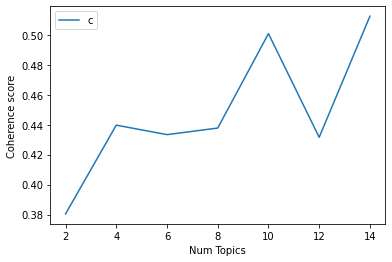

In [38]:
#limit=15; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

- ¿Cuál modelo conservar? Miraremos la métrica de coherencia...

In [40]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3805
Num Topics = 4  has Coherence Value of 0.4397
Num Topics = 6  has Coherence Value of 0.4334
Num Topics = 8  has Coherence Value of 0.4377
Num Topics = 10  has Coherence Value of 0.5007
Num Topics = 12  has Coherence Value of 0.4316
Num Topics = 14  has Coherence Value of 0.5123


In [41]:
# Select the model and print the topics
optimal_model = model_list[4]

- Guardaremos el mejor modelo en un archivo para poder reutilizarlo despues sin volver a entrenar...

In [44]:
archivo='./output/optimal_model_catrillanca_10'

In [45]:
optimal_model.save(archivo)

- En cualquier momento, se puede volver a cargar el model desde el archivo, sin volver a entrenar el modelo...

In [48]:
from gensim.models import LdaModel

optimal_model = LdaModel.load(archivo, mmap='r')

- Visualizemos el modelo de tópicos

In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, dataset, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.340391  0.068151       1        1  60.570616
8     -0.305393 -0.010848       2        1  16.492448
1     -0.277704  0.043393       3        1  15.805666
5      0.032353 -0.401829       4        1   3.531473
4      0.119032  0.043869       5        1   1.458445
2      0.147217  0.056715       6        1   1.201279
9      0.159813  0.054307       7        1   0.455221
0      0.158213  0.051689       8        1   0.380908
7      0.154028  0.047647       9        1   0.090276
3      0.152832  0.046906      10        1   0.013666, topic_info=                                Term         Freq        Total Category  \
3153                               }  1959.000000  1959.000000  Default   
3152                               {   722.000000   722.000000  Default   
92                                 “  2971.000000  2971.000000  Default   
10                              años  2671.000000  2671.000000  Default   
11                              caso  2133.000000  2133.000000  Default   
...                              ...          ...          ...      ...   
32687             temas prioritarios     0.001287     0.400486  Topic10   
16535              triunfo electoral     0.001303     0.419622  Topic10   
16427                jefes comunales     0.001303     0.505890  Topic10   
32670  convencionales constituyentes     0.001287     0.409085  Topic10   
32673           desafíos electorales     0.001287     0.404562  Topic10   

       logprob  loglift  
3153   30.0000  30.0000  
3152   29.0000  29.0000  
92     28.0000  28.0000  
10     27.0000  27.0000  
11     26.0000  26.0000  
...        ...      ...  
32687 -10.5606   3.1577  
16535 -10.5484   3.1232  
16427 -10.5484   2.9362  
32670 -10.5606   3.1364  
32673 -10.5606   3.1475  

[454 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
771       1  0.110314        #
771       2  0.888756        #
4043      6  1.001907       //
4044      6  1.001907  24horas
4047      6  0.994181        =
...     ...       ...      ...
92        2  0.039715        “
92        3  0.470858        “
216       1  0.489236        ”
216       2  0.051043        ”
216       3  0.459821        ”

[445 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 9, 2, 6, 5, 3, 10, 1, 8, 4])

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

### 8. ¿Cuál es el tópico principal de cada documento?

- Podemos analizar cuál es el tópico principal de cada documento

In [53]:
### NO MODIFICAR ###

def format_topics_documents(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_documents(ldamodel=optimal_model, corpus=dataset, texts=noticias)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,8.0,0.5353,"}, años, fiscal, caso, casos, investigación, a...",El Instituto Nacional de Derechos Humanos (IND...
1,1,6.0,0.4799,"gobierno, ministro, parte, año, país, “, perso...",Hasta el Palacio de la Moneda llegó Marcelo Ca...
2,2,1.0,0.5068,"“, ”, policía, general, lugar, carabineros, mo...",SANTIAGO.- A casi cuatro meses de la muerte de...
3,3,6.0,0.5163,"gobierno, ministro, parte, año, país, “, perso...","Hace unos días Marcelo Catrillanca, padre de C..."
4,4,6.0,0.7267,"gobierno, ministro, parte, año, país, “, perso...","Durante la mañana de este jueves, un grupo de ..."
5,5,6.0,0.5430,"gobierno, ministro, parte, año, país, “, perso...","Marcelo Catrillanca, padre del comunero mapuch..."
6,6,6.0,0.4237,"gobierno, ministro, parte, año, país, “, perso...","Durante la tarde de este lunes, fue detenido M..."
7,7,1.0,0.2663,"“, ”, policía, general, lugar, carabineros, mo...","Este lunes fue detenido Marcelo Catrillanca, p..."
8,8,6.0,0.6756,"gobierno, ministro, parte, año, país, “, perso...",El padre de Camilo Catrillanca realizó un llam...
9,9,1.0,0.4987,"“, ”, policía, general, lugar, carabineros, mo...",Un comunero mapuche murió tras ser herido a ba...


- La variable "df_dominant_topic" contiene una columna "Dominant_topic" que indica el tópico principal en cada documento y cuál su porcentaje (variable "Topic_Perc_contrib")

- Podemos contar cuántos documentos son por tópicos principales:

In [54]:
from pandasql import sqldf 

In [55]:
result = sqldf("SELECT Dominant_Topic, count(*) as nb_noticias FROM df_dominant_topic GROUP BY Dominant_Topic ORDER BY count(*) DESC")
result

,Dominant_Topic,nb_noticias
0,6.0,2129
1,8.0,421
2,1.0,345
3,2.0,20
4,5.0,15
5,7.0,1


- ¿Cuál es la noticia más representativa de cada tópcio?

- Tópico 1

In [58]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=1.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,95,1.0,0.7821,"“, ”, policía, general, lugar, carabineros, momento, operativo, personas, información","Al momento del baleo que finalmente le provocó la muerte, Camilo Catrillanca iba acompañado en su tractor por un adolescente de 15 años que posteriormente fue detenido por Carabineros que participaron en el operativo. El menor, de iniciales M.A.P.C., entregó su testimonio al Instituto Nacional de Derechos Humanos (INDH), donde reveló pormenores del cuestionado procedimiento. En detalles dados a conocer por Cooperativa, aseguró que los carabineros a cargo del operativo cambiaron sus cámaras tras disparar contra ellos. : General Soto confirma que carabineros involucrados en muerte de Camilo Catrillanca no llevaban cámaras para grabarLeer más ""Él iba con Camilo Catrillanca en el tractor y de repente se encuentran con Carabineros que empiezan a disparar primero balines de goma y después balas. En ese minuto Camilo Catrillanca le dice (al menor) 'agáchate que están disparando', se agachan y él ve a Camilo botando un líquido por la nariz y se da cuenta que le dispararon"", señaló Consuelo..."


- Tópico 2

In [59]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=2.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,2804,2.0,0.5089,"{, function, =, block, duracion, relative, volumen, defecto, //, 24horas","El Presidente de la República, Sebastián Piñera, enfrentó la noche de este miércoles al panel del programa ""Llegó tu Hora"" de TVN, instancia en la cual abordó los principales temas de la contingencia como la crisis que sacude a Carabineros y a las Fuerzas Armadas, además de la actual situación de TVN, entre otras temáticas. Sobre los reiterados cuestionamientos al General director de la policía uniformada, Hermes Soto, el Mandatario descartó pedirle la renuncia en lo pronto y aseguró que le exigió que entregara toda la información correspondiente al homicidio de Camilo Catrillanca: ""Me reuní con el general Hermes Soto y con los generales inspectores. Les pedí que entregaran toda la información que tenían a la fiscalía, porque ese es su deber. También pedí que la eficacia operacional de Carabineros mejorara sustancialmente"". .storyVideoBody, controlBody2916357 {display:block; position:relative; margin:1em 0; padding:0; clear:both; overflow:hidden;width: 650px;}Presidente Piñera por ..."


- Tópico 5

In [61]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=5.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,2199,5.0,0.5541,"crisis, millones, confianza, ministros, Chile Vamos, veces, oficialismo, partido, clase, pesos","TEMUCO. – Después de la sorpresiva derrota ante Costa Rica en Rancagua, la selección chilena necesitaba encontrarse con los abrazos para cerrar de buena manera el ""traumático y tortuoso""período del recambio, según las propias palabras del técnico Reinaldo Rueda. Noticia relacionada La ""Roja"" de Rueda no da espectáculo, pero mejora y golea a Honduras gracias a tres penales Y lo hizo con creces venciendo por 4-1 a Honduras en Temuco . Una victoria contundente y que denotó una leve mejoría en el equipo. Pero sin lugar a duda el duelo disputado en el estadio Germán Becker no será recordado por lo futbolístico, sino que por todo lo que generó antes y durante su desarrollo. El minuto de silencio que no fue y el apoyo de los jugadores Desde que la ""Roja"" pisó suelo temuquense el domingo se hizo sentir la t ensión por el conflicto mapuche que se vive en la zona. Pese a que la ANFP deslizó la opción de realizar un minuto de silencio por la muerte del comunero Camilo Catrillanca , fina..."


- Tópico 6

In [62]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=6.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,414,6.0,0.9549,"gobierno, ministro, parte, año, país, “, personas, años, oposición, ”","PUNTA ARENAS.- Luego de visitar Puerto Williams, el Presidente Sebastián Piñera arribó esta noche en Santiago, cerrando así una jornada que en la capital estuvo marcada por las críticas de la oposición al rol que ha tenido el ministro del Interior, Andrés Chadwick , tras la muerte del comunero mapuche Camilo Catrillanca. La presión de la oposición exigiendo la renuncia del ministro y la evaluación de una posible acusación constitucional en su contra ha crecido, luego de que el renunciado general de Carabineros Mauro Victtoriano declarara supuestamente que él le informó a Chadwick que el comunero no estaba armado en el operativo en que murió. Noticias relacionadas Chadwick ante críticas de la oposición por caso Catrillanca: ""No he pensado en renunciar"" El informe de Carabineros que recibió el ministro Chadwick horas después de la muerte de Catrillanca Versión ante la cual, Chadwick reconoció ayer que ""lamentablemente había una muy mala comunicación e interferencia, por lo ta..."


- tópico 7

In [63]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=7.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,1943,7.0,0.4661,"violencia policial, consigna, shared, licencia, post, orden de detención, this post, this, causa derivada, licencia médica","Salir a comer junto a tu perro nunca fue tan divertido como en Ushisuke, una cadena de restaurantes que se ubica en Tokyo y Yakohama, en Japón, donde los comensales pueden ir acompañados de sus caninos, sin ningún problema. En el particular restaurante no solo cocinan deliciosas carne para ti, sino también que también tienen disponible un menú exclusivo para tu perro. El lugar no ha escapado de la fiebre viral y usuarios aprovechan para compartir en las redes sociales imágenes y videos cuando visitan el lugar junto a sus peludos. View this post on InstagramA post shared by わたあめ (@wata201312) A post shared by わたあめ (@wata201312) MIRA TAMBIÉN: Paleontólogo chileno bautiza como ""Camilo Catrillanca"" a desaparecida especie de pez espada Las mascotas pueden sentarse a la mesa y ordenar, además el alimento para las criaturas parece ser ligeramente diferente de lo que comen: View this post on InstagramA post shared by もち&あずき (@mocci_azuki) A post shared by もち&あずき (@mocci_azuki) View this ..."


- tópico 8

In [64]:
pd.options.display.max_colwidth = 1000

result = sqldf("SELECT * FROM df_dominant_topic WHERE dominant_topic=8.0 ORDER BY Topic_Perc_Contrib DESC LIMIT 1")
result

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,24,8.0,0.9012,"}, años, fiscal, caso, casos, investigación, abogado, sistema, delitos, prisión","La Corte de Apelaciones de Temuco determinó la prisión preventiva de los excarabineros condenados en el marco del caso Catrillanca. Se trata de los expolicías Carlos Alarcón, Raúl Ávila y Braulio Valenzuela, implicados en la muerte del joven comunero mapuche, Camilo Catrillanca, quienes permanecían sólo con arresto domiciliario total. AHORA Caso Catrillanca: Corte de Temuco ordena prisión preventiva de carabineros Carlos Alarcón, Raúl Avila y Braulio Valenzuela. pic.twitter.com/zPS5B2zOXF— Poder Judicial Chile (@PJudicialChile) January 19, 2021 AHORA Caso Catrillanca: Corte de Temuco ordena prisión preventiva de carabineros Carlos Alarcón, Raúl Avila y Braulio Valenzuela. pic.twitter.com/zPS5B2zOXF Cabe recordar que el Tribunal en Lo Penal de Angol condenó al exsargento Carlos Alarcón como autor de los delitos de homicidio simple consumado de Catrillanca y homicidio frustrado del menor M.A.P.C. Además, dictó veredicto condenatorio contra el exsargento Raúl Ávila por apremios ilegít..."


__¿Conclusiones?__

- El tópico de "violaciones/democracia/manifestaciones" nunca es el tópico central de la noticia que hablan de Catrillanca. Es un tópico al segundo plano.

- ...

__¿Cómo nombrar los tópicos?__

Del más frecuente al menos frecuente...

6 --> Consecuencias del caso Catrillanca para el gobierno y sus ministros

8 --> Consecuencias judiciales del caso Catrillanca

1 --> Relato del caso Catrillanca

2 --> Noticias que integran un medio con ruido HTML (video, redes sociales)

5 --> Crisis de confianza instituciones Carabiñeros y Fuerzas Armadas

